# ELISA analysis
Analysis of ELISA experiments using different viruses (3) and subset of peptides (6) + buffer + empty.

In [1]:
import sys
import os
from importlib import reload
import pandas as pd
import numpy as np

from sklearn import preprocessing
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go


from flutype.utils import django_setup
from flutype.models import Spot

import analysis2 as a2
import preprocessing as pp

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

****************************************
RUNNING IN DEVELOP
****************************************


## Load Elisa Data
- 96 well plates, peptides in rows

In [2]:
reload(preprocessing)
reload(a2)
studies = ["elisa_2018_04_23"]
collections_not = ["2018_04_23-4"]           
           
spots_dj = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots_dj = spots_dj.exclude(raw_spot__raw_spot_collection__sid__in=collections_not)

data_elisa = a2.Data(spots_dj=spots_dj,impute=True)#.outlier_filtering()

## Normalization by Analyte Buffer
- normalize every virus by the median buffer concentration of the respective virus (mean of three repeats per microtiter plate)
- buffer columns are normalized by respective buffer row

In [3]:
# results dictionary
frames = {}

# iterate over collections and analyte batch
for cn, d in data_elisa.spots_pd.groupby(["Collection", "Analyte Batch"]):
    # normalize with respective buffer value
    x = d.copy()
    buffer_ref = d[d["Ligand Batch"] == "Buffer001"].Intensity.mean()
    x.Intensity = d.Intensity/buffer_ref
    frames[cn] = x
spots_pd_norm = pd.concat(frames)
data_elisa_norm1 = a2.Data(spots_pd=spots_pd_norm,impute=True)

In [4]:
#data_elisa_norm1.x

## Normalization by Ligand Buffer
- normalize row with respective ligand buffer, i.e. the peptide with only buffer (no virus)

In [5]:
frames = {}
for cn, d in data_elisa.spots_pd.groupby(["Collection", "Ligand Batch"]):
    x = d.copy()
    buffer_ref = d[d["Analyte Batch"] == "Buffer001"]["Intensity"].mean()
    x["Intensity"] = d["Intensity"]/buffer_ref
    frames[cn] = x
spots_pd_norm = pd.concat(frames)
data_elisa_norm2 = a2.Data(spots_pd=spots_pd_norm,impute=True)

## Normalization on Both

In [6]:
frames = {}
for cn, d in  data_elisa_norm1.spots_pd.groupby(["Collection","Ligand Batch"]):
    x = d.copy()
    x["Intensity"] = d["Intensity"]/d[d["Analyte Batch"] == "Buffer001"]["Intensity"].mean()
    frames[cn]=x
spots_pd_norm = pd.concat(frames)
data_elisa_norm3 = a2.Data(spots_pd=spots_pd_norm,impute=True)

## Subtract Background (empty), than normalize

In [7]:
frames = {}
for cn, d in  data_elisa.spots_pd.groupby(["Collection","Analyte Batch"]):
    x = d.copy()
    x["Intensity"] = d["Intensity"]-d[d["Ligand Batch"] == "Empty"]["Intensity"].mean()
    x["Intensity"] = x["Intensity"]/x[x["Ligand Batch"] == "Buffer001"]["Intensity"].mean()
    frames[cn]=x
spots_pd_norm = pd.concat(frames)

frames = {}
for cn, d in  spots_pd_norm.groupby(["Collection","Ligand Batch"]):
    x = d.copy()
    x["Intensity"] = d["Intensity"]/d[d["Analyte Batch"] == "Buffer001"]["Intensity"].mean()
    frames[cn]=x
spots_pd_norm = pd.concat(frames)

spots_pd_norm.at[spots_pd_norm["Ligand Batch"] == "Empty","Intensity"] = 0  # remove NaNs/Infs 
data_elisa_norm4 = a2.Data(spots_pd=spots_pd_norm,impute=True)

## Relativ Standard Deviation of Analyte Batch 
The relative standard deviation (coeffcient of variation) of well intensities with similar viruses and peptides are calculated. Intensities are considered from all microwell plates contained in the studies. Relative standard deviation  in mean units of the respective dataset. The relative standard deviation (error) is containing both sources of systematic and random errors.
- how large is the standard deviation across repeats and replicates

In [8]:
ma_ana = data_elisa.mean_on_analyte_batch().groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
ma_lig = data_elisa.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm1 = data_elisa_norm1.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_ana_norm1 = data_elisa_norm1.mean_on_analyte_batch().groupby(["Analyte Batch"]).mean()["Intensity_rsd"]

ma_lig_norm2 = data_elisa_norm2.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm3 = data_elisa_norm3.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm4 = data_elisa_norm4.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]

/home/janekg89/Develop/Pycharm_Projects/flutype_analysis_web/preprocessing.py:94: RuntimeWarning:

invalid value encountered in double_scalars



In [9]:
display_side_by_side(pd.DataFrame(ma_ana),pd.DataFrame(ma_lig))

,Intensity_rsd
Analyte Batch,
A/Aichi/2/68(H3N2)-4-10,0.480157
A/California/07/2009(H1N1)-3-10,0.563132
A/Panama/2007/1999(H3N2)-3-10,0.495097
Buffer001,0.484280
,Intensity_rsd
Ligand Batch,
Buffer001,0.545691
Empty,0.487104
P052-0.3,0.534766


In [10]:
display_side_by_side(pd.DataFrame(ma_ana_norm1), pd.DataFrame(ma_lig_norm1))

,Intensity_rsd
Analyte Batch,
A/Aichi/2/68(H3N2)-4-10,0.533655
A/California/07/2009(H1N1)-3-10,0.498481
A/Panama/2007/1999(H3N2)-3-10,0.419885
Buffer001,0.426720
,Intensity_rsd
Ligand Batch,
Buffer001,0.244464
Empty,0.588535
P052-0.3,0.470386


Systematic errors induced by variing properties related to each microwell can be countered by normalization. The rsd after normalization between microwell plates can not be lower than within the microwell plates. 



In [11]:
mc_ana = data_elisa.mean_on_collection().groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
mc_lig = data_elisa.mean_on_collection().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]

In [12]:
display_side_by_side(pd.DataFrame(mc_ana), pd.DataFrame(mc_lig))

,Intensity_rsd
Analyte Batch,
A/Aichi/2/68(H3N2)-4-10,0.313507
A/California/07/2009(H1N1)-3-10,0.296989
A/Panama/2007/1999(H3N2)-3-10,0.252207
Buffer001,0.330283
,Intensity_rsd
Ligand Batch,
Buffer001,0.227208
Empty,0.326975
P052-0.3,0.387070


The following table shows the proportion of variance which is allready whithin the microwell plate:
    

In [13]:
display_side_by_side(pd.DataFrame(mc_ana/ma_ana), pd.DataFrame(mc_lig/ma_lig))

,Intensity_rsd
Analyte Batch,
A/Aichi/2/68(H3N2)-4-10,0.652927
A/California/07/2009(H1N1)-3-10,0.527389
A/Panama/2007/1999(H3N2)-3-10,0.509409
Buffer001,0.682007
,Intensity_rsd
Ligand Batch,
Buffer001,0.416368
Empty,0.671262
P052-0.3,0.723812


- around 60% of the variance are within the microwell, additional 40% are added between microwells

## Look at ability of peptides to distinguish viruses
- how different is the signal of the peptides for different viruses

In [14]:
mlig_lig = data_elisa.mean_on_collection_by_lig_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]

In [15]:
mlig_lig_norm1 = data_elisa_norm1.mean_on_collection_by_lig_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
mlig_lig_norm2 = data_elisa_norm2.mean_on_collection_by_lig_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
mlig_lig_norm3 = data_elisa_norm3.mean_on_collection_by_lig_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
mlig_lig_norm4 = data_elisa_norm4.mean_on_collection_by_lig_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]

/home/janekg89/Develop/Pycharm_Projects/flutype_analysis_web/preprocessing.py:121: RuntimeWarning:

invalid value encountered in double_scalars



Generally all relevant information is convoluted in the differentiability of signals from the same peptides but different viruses. 

In [16]:
mlig_lig_pd = pd.DataFrame(mlig_lig)
mlig_lig_pd["Intensity_rsd Ratio Collection"] = mlig_lig/mc_lig
mlig_lig_pd["Intensity_rsd Ratio Study"] = mlig_lig/ma_lig
mlig_lig_pd["Intensity_rsd  Norm1 Ratio Study"] = mlig_lig_norm1/ma_lig_norm1
mlig_lig_pd["Intensity_rsd  Norm2 Ratio Study"] = mlig_lig_norm2/ma_lig_norm2
mlig_lig_pd["Intensity_rsd  Norm3 Ratio Study"] = mlig_lig_norm3/ma_lig_norm3
mlig_lig_pd["Intensity_rsd  Norm4 Ratio Study"] = mlig_lig_norm4/ma_lig_norm4

mlig_lig_pd.loc["Mean"] = mlig_lig_pd.mean()
mlig_lig_pd

,Intensity_rsd,Intensity_rsd Ratio Collection,Intensity_rsd Ratio Study,Intensity_rsd Norm1 Ratio Study,Intensity_rsd Norm2 Ratio Study,Intensity_rsd Norm3 Ratio Study,Intensity_rsd Norm4 Ratio Study
Ligand Batch,,,,,,,
Buffer001,0.412443,1.815264,0.755819,0.979622,0.864454,0.979622,1.093040
Empty,0.555397,1.698594,1.140202,0.969404,0.892004,0.842306,NaN
P052-0.3,0.689160,1.780453,1.288712,1.203604,1.430225,1.002622,-17.551367
P079-0.3,0.666906,2.206500,1.431587,1.239544,1.544994,1.097815,-0.043828
P116-0.3,0.385779,1.457550,0.802642,0.936910,1.148487,0.927532,0.117788
P124-0.3,0.359558,1.418850,0.951614,0.935091,1.139803,0.857115,0.593262
P130-0.3,0.543021,1.777391,1.052863,0.911229,0.957303,0.865489,0.993596
P135-0.3,0.503410,1.578751,0.789432,0.826079,1.022209,0.880107,0.317608
Mean,0.514459,1.716669,1.026609,1.000185,1.124935,0.931576,-2.068557


The proportion between signal and noise.

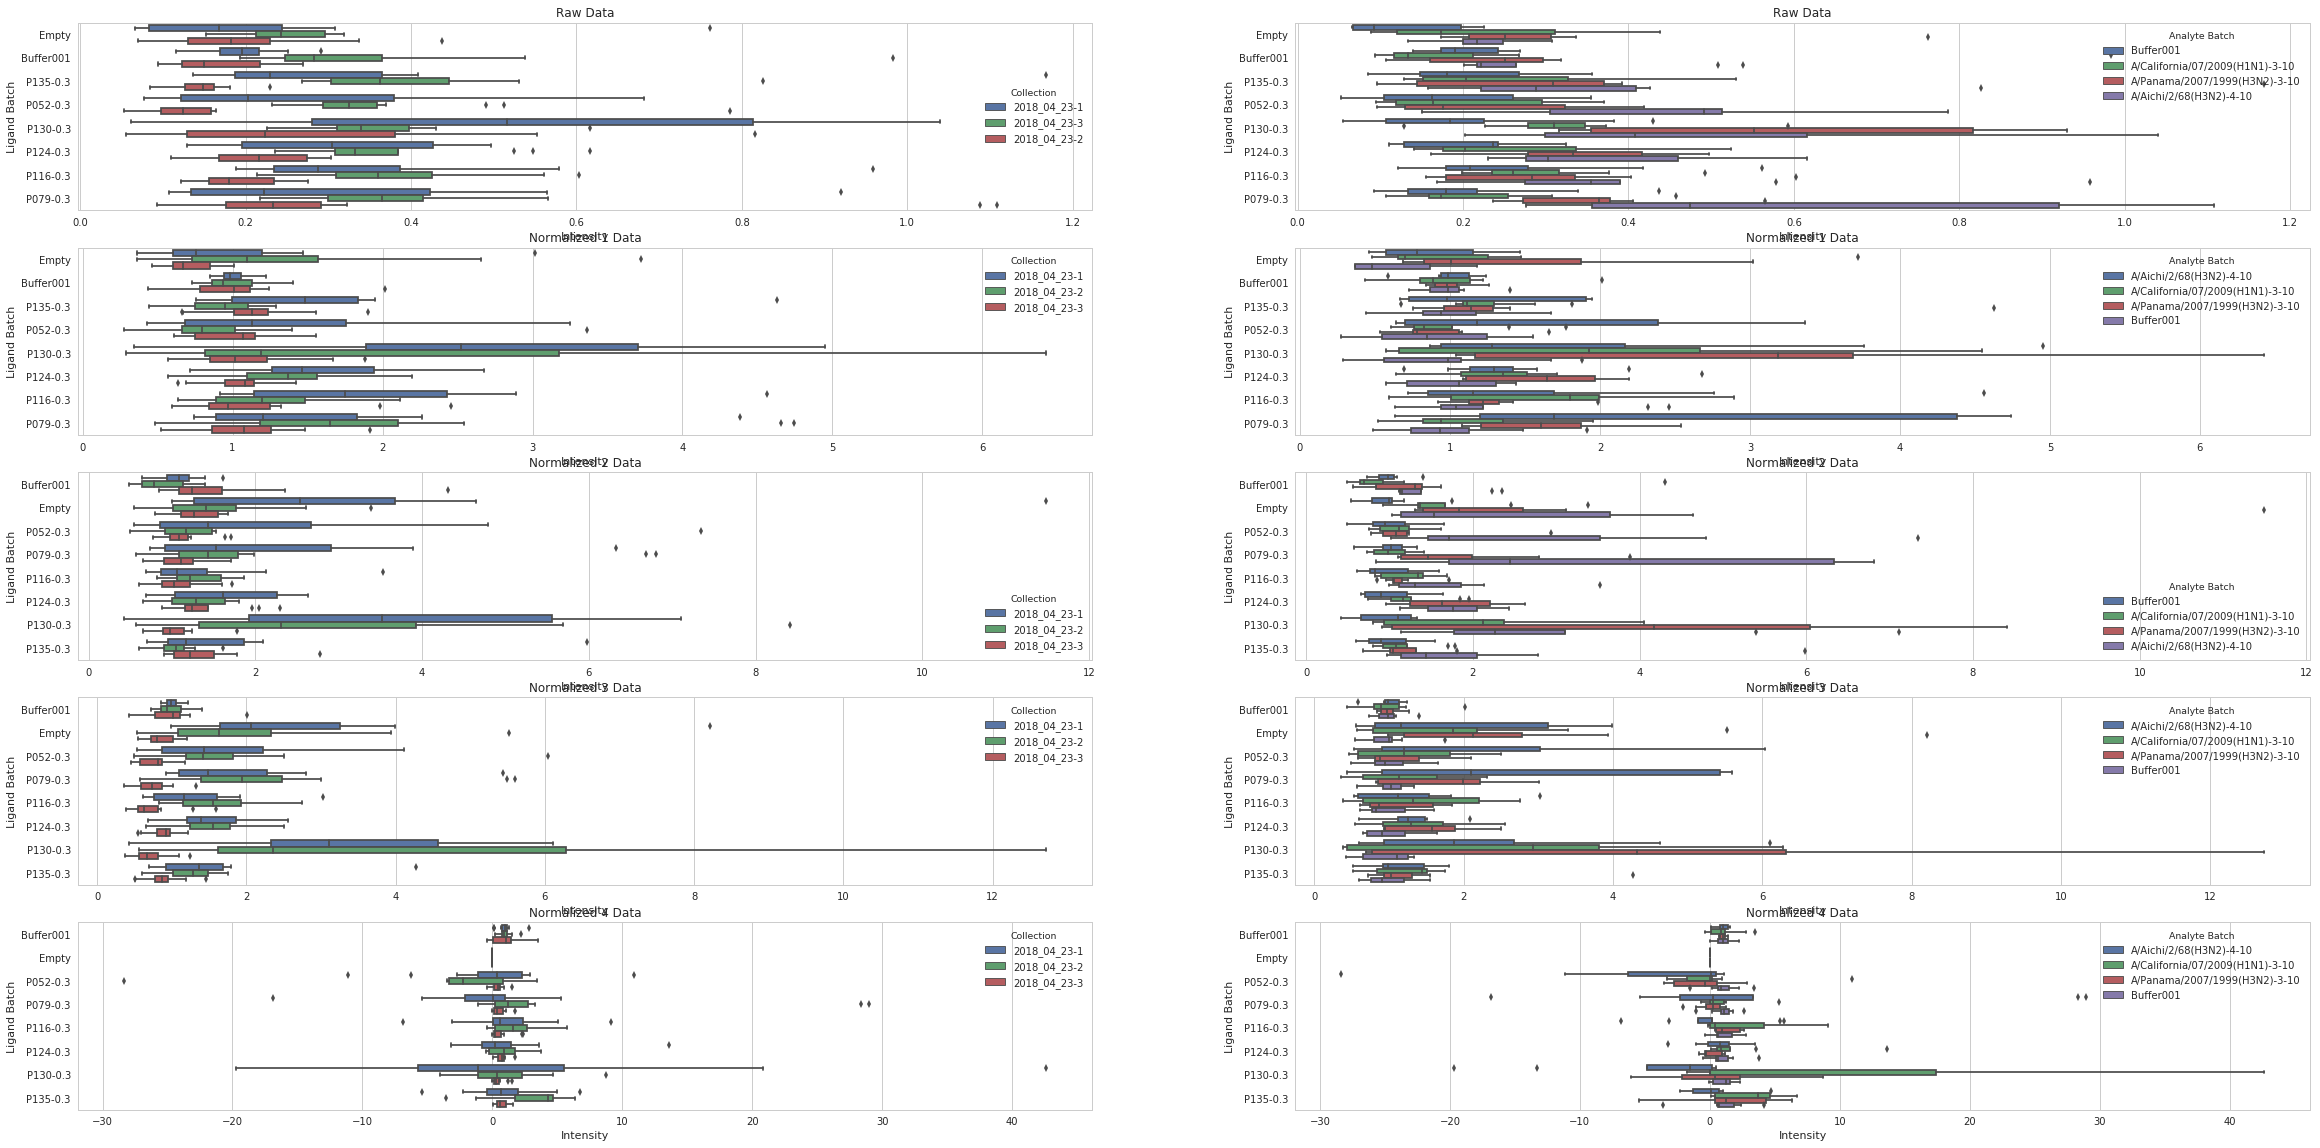

In [17]:
fig ,ax = plt.subplots(ncols=2,nrows=5,figsize=(40,20))
ax[0,0].set_title("Raw Data")
ax[0,1].set_title("Raw Data")
ax[1,0].set_title("Normalized 1 Data")
ax[1,1].set_title("Normalized 1 Data")
ax[2,0].set_title("Normalized 2 Data")
ax[2,1].set_title("Normalized 2 Data")
ax[3,0].set_title("Normalized 3 Data")
ax[3,1].set_title("Normalized 3 Data")
ax[4,0].set_title("Normalized 4 Data")
ax[4,1].set_title("Normalized 4 Data")
sns.boxplot(data=data_elisa.spots_pd, x="Intensity", hue="Collection", y="Ligand Batch", ax=ax[0,0])
sns.boxplot(data=data_elisa.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[0,1],)
sns.boxplot(data=data_elisa_norm1.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[1,0])
sns.boxplot(data=data_elisa_norm1.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[1,1],)
sns.boxplot(data=data_elisa_norm2.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[2,0])
sns.boxplot(data=data_elisa_norm2.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[2,1],)
sns.boxplot(data=data_elisa_norm3.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[3,0])
sns.boxplot(data=data_elisa_norm3.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[3,1],)
sns.boxplot(data=data_elisa_norm4.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[4,0])
sns.boxplot(data=data_elisa_norm4.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[4,1],)

plt.show()

In [18]:
sns.boxplot(data=data_elisa_norm1.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[1,1],)


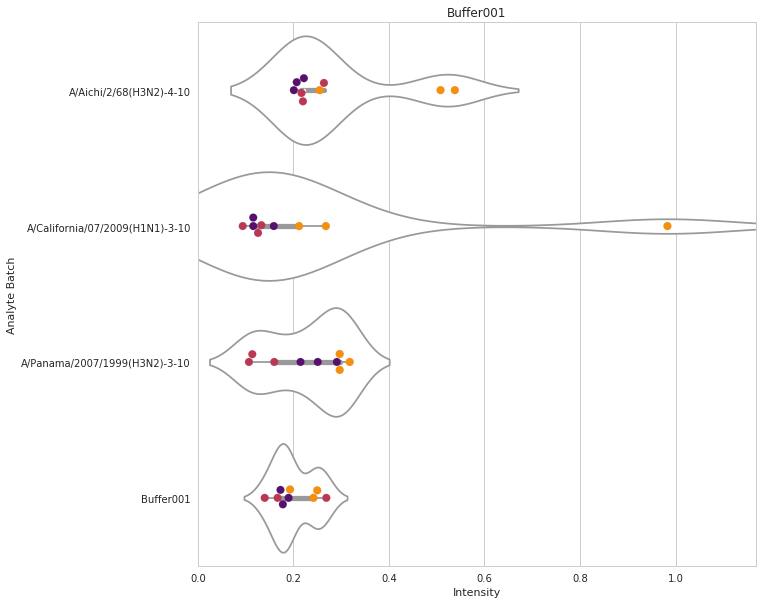

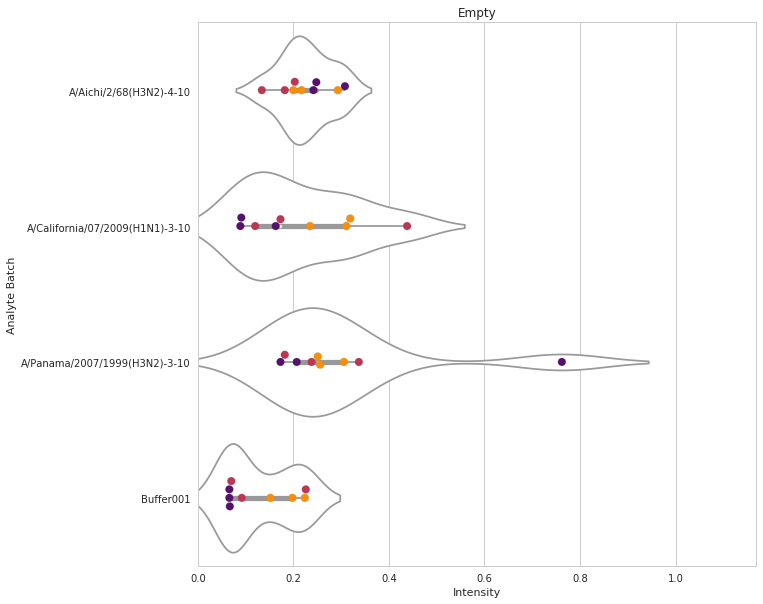

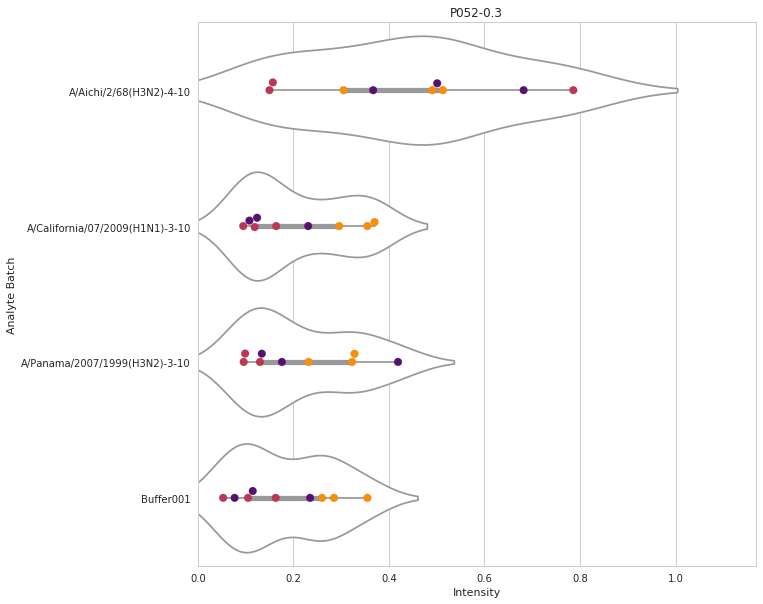

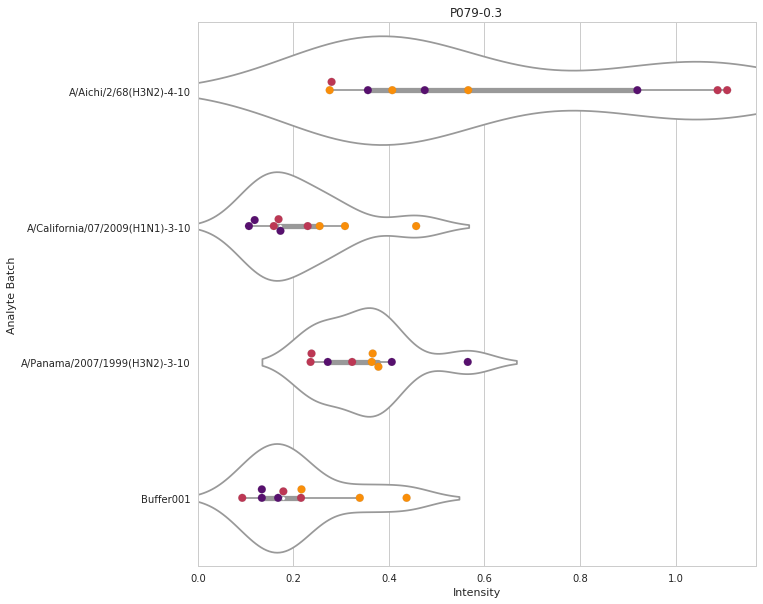

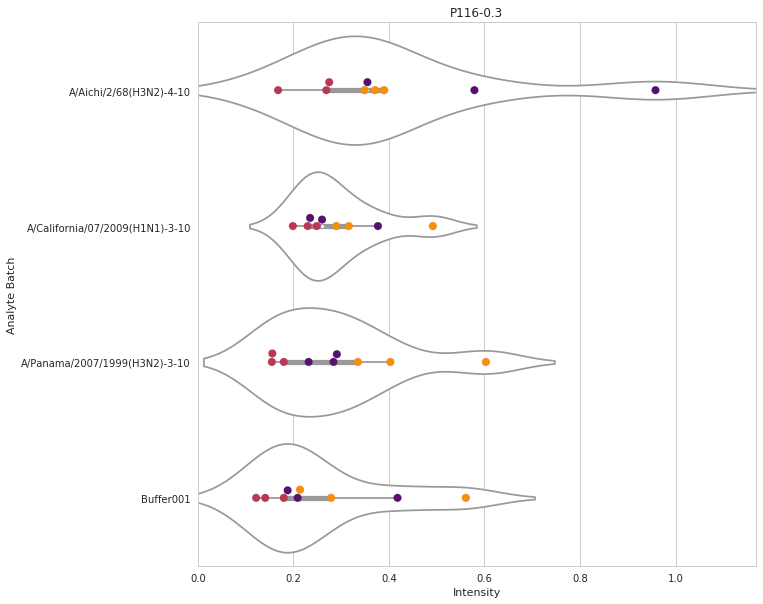

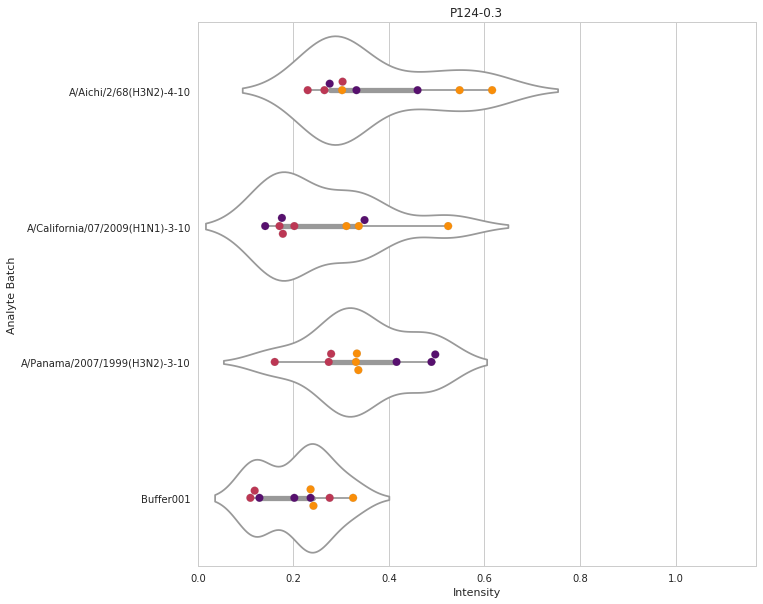

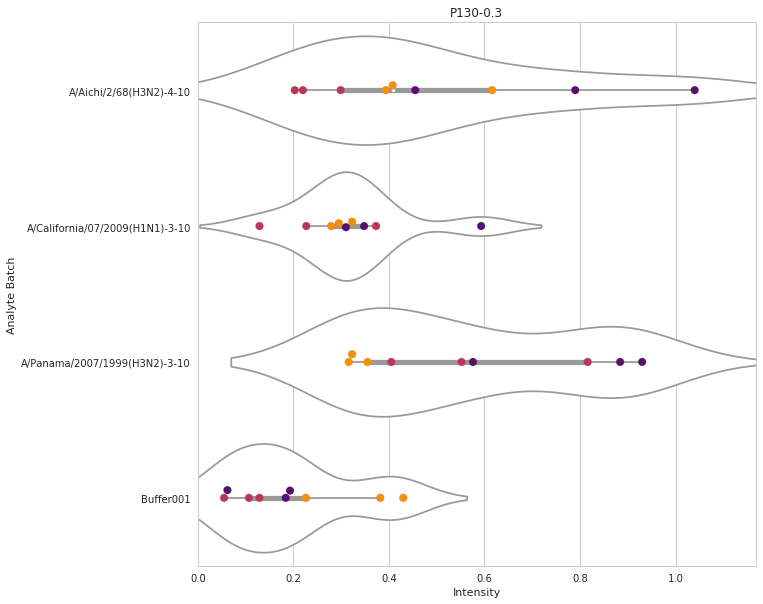

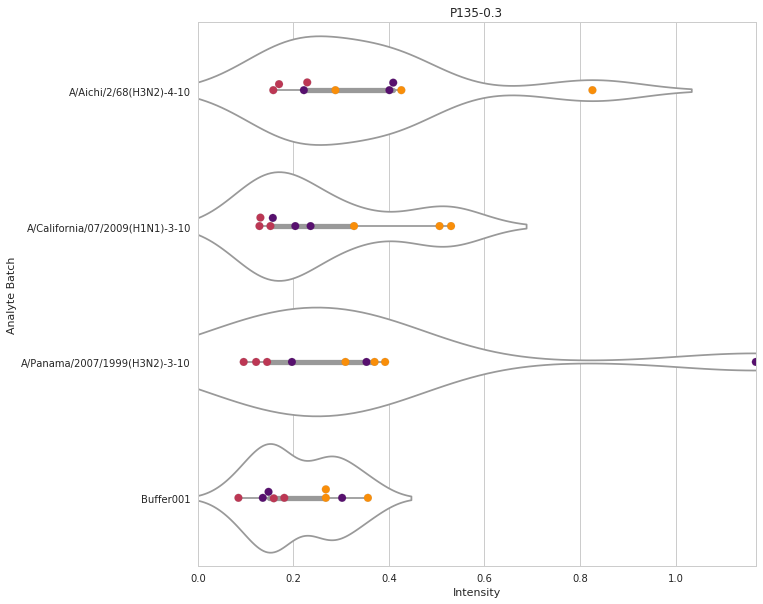

In [19]:
#x_max = data_elisa_norm1.spots_pd["Intensity"].max()
#for n,d in data_elisa_norm1.spots_pd.groupby("Ligand Batch"):
x_max = data_elisa.spots_pd["Intensity"].max()
for n,d in data_elisa.spots_pd.groupby("Ligand Batch"):
    #d = d.subset_ligand_batches(["P130-0.3"])
    fig ,ax = plt.subplots(figsize=(10,10))
    ax.set_title(n)
    ax.set_xlim([0,x_max])
    ax = sns.violinplot(y="Analyte Batch",
                        x="Intensity",
                        bw=.5, 
                        #hue="Collection",
                        scale="width", 
                        data=d.sort_values(by=["Analyte Batch", "Collection"]),
                        #split=True,
                        color="white",
                        #cut=1,

                        )
    ax = sns.swarmplot(y="Analyte Batch",
                       hue="Collection", 
                       x="Intensity",
                       palette=sns.color_palette("inferno",n_colors=3),
                       #color="white",
                       data=d.sort_values(by=["Analyte Batch", "Collection"]),
                       size=8,
                       #split=True,
                       edgecolor="grey",
                       linewidth=0.1,)

    ax.legend_.remove()
    plt.show()

 ## Correlation Plots

In [20]:
cmap = matplotlib.cm.get_cmap('Accent')

In [21]:
colors =  cmap(np.linspace(0,1,num=6))
color_list = []
for color in colors:
    for i in range(3):
        color_list.append(color)
color_list += [np.array([0 ,0 , 0, 0]) ]

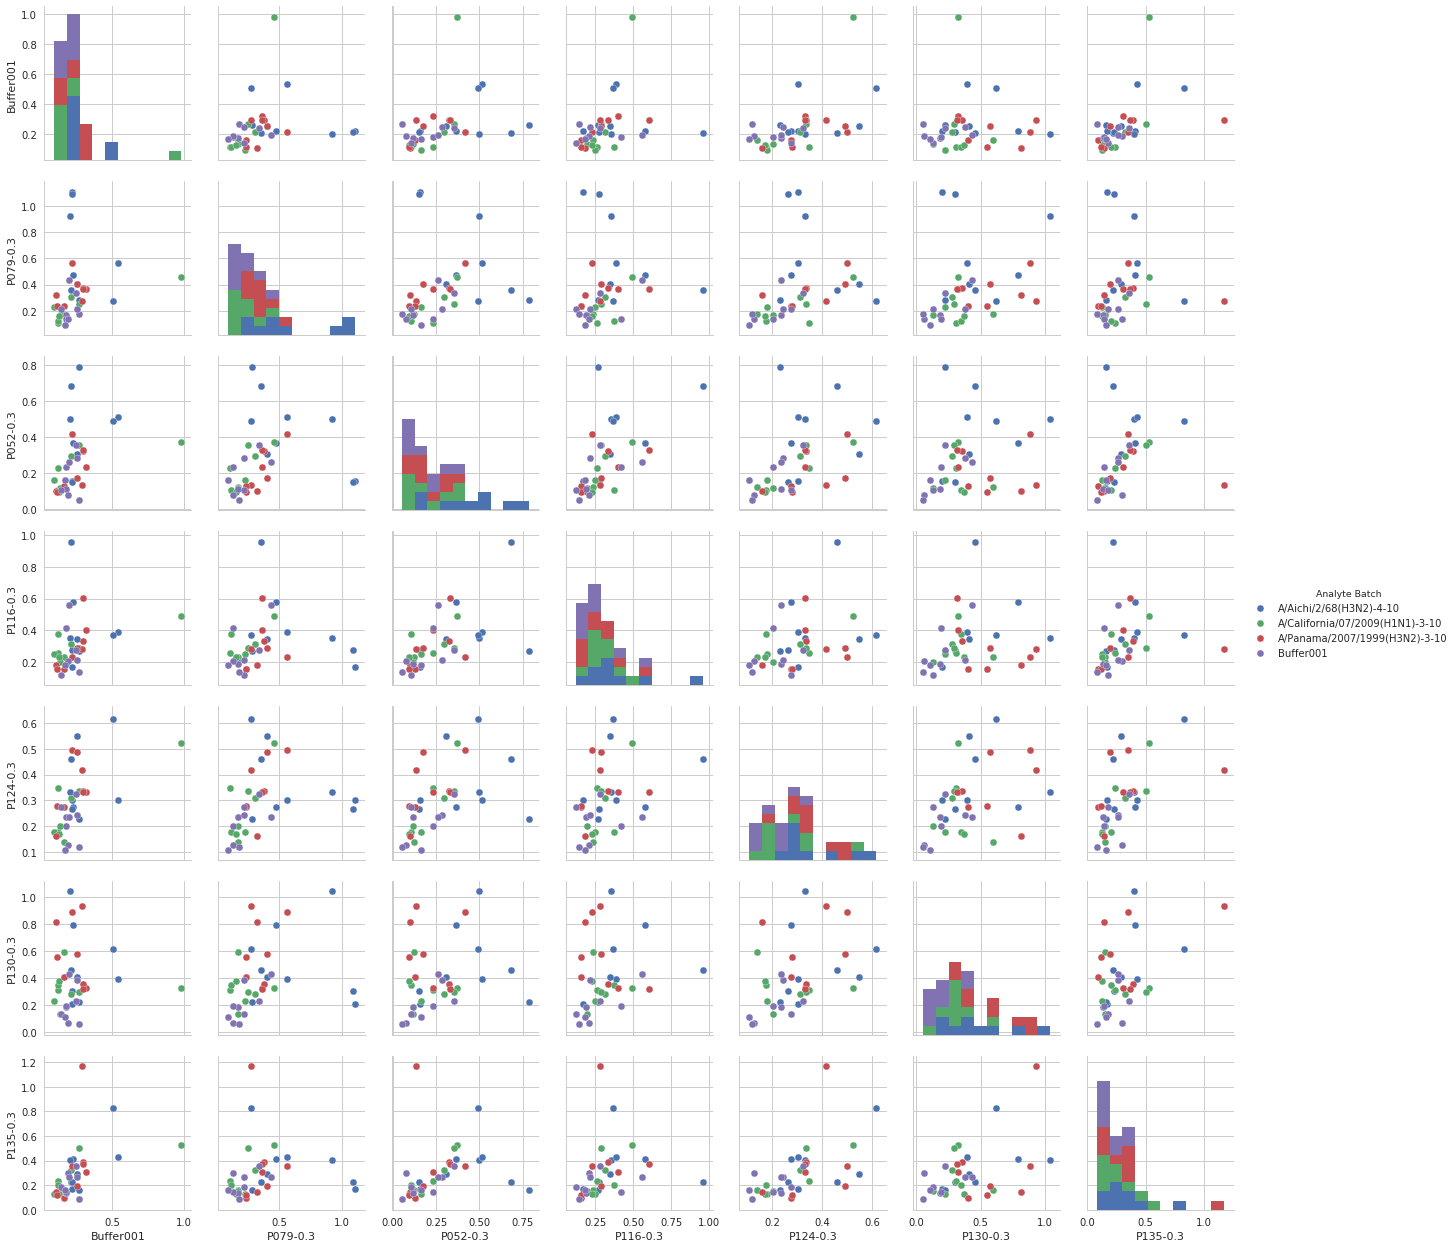

In [22]:
sns.pairplot(data=data_elisa.x.reset_index(),vars=["Buffer001","P079-0.3","P052-0.3","P116-0.3","P124-0.3","P130-0.3","P135-0.3"],hue="Analyte Batch")#,palette=color_list)#,markers= 6*["o","s","D"]+["x"])

In [23]:
d_analayte_x = data_elisa.spots_pd.pivot_table(values="Intensity",columns=["Ligand Batch","Analyte Batch Concentraion", "Replica"], index=["Analyte"])
d_new = d_analayte_x.transpose()

In [24]:
colors =  cmap(np.linspace(0,1,num=3))
color_list = []
for color in colors:
    #for i in range(3):
        color_list.append(color)
color_list += [np.array([0 ,0 , 0, 0]) ]

Correlation of Viruses 

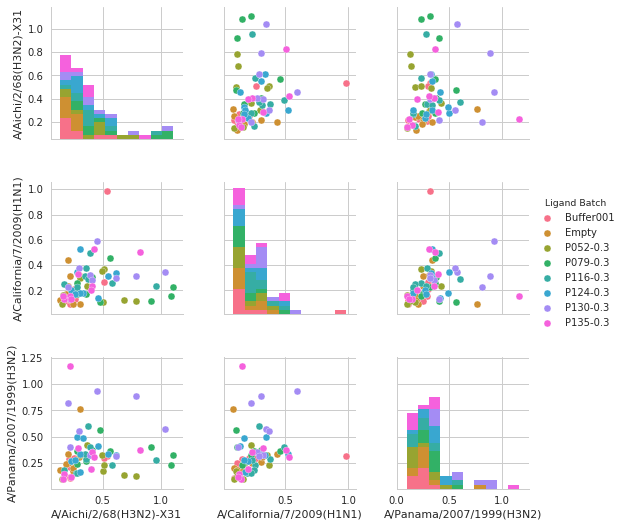

In [25]:
sns.pairplot(data=d_new.reset_index(), hue="Ligand Batch", vars=['A/Aichi/2/68(H3N2)-X31',  'A/California/7/2009(H1N1)', 'A/Panama/2007/1999(H3N2)'])

## Heat/Cluster Map

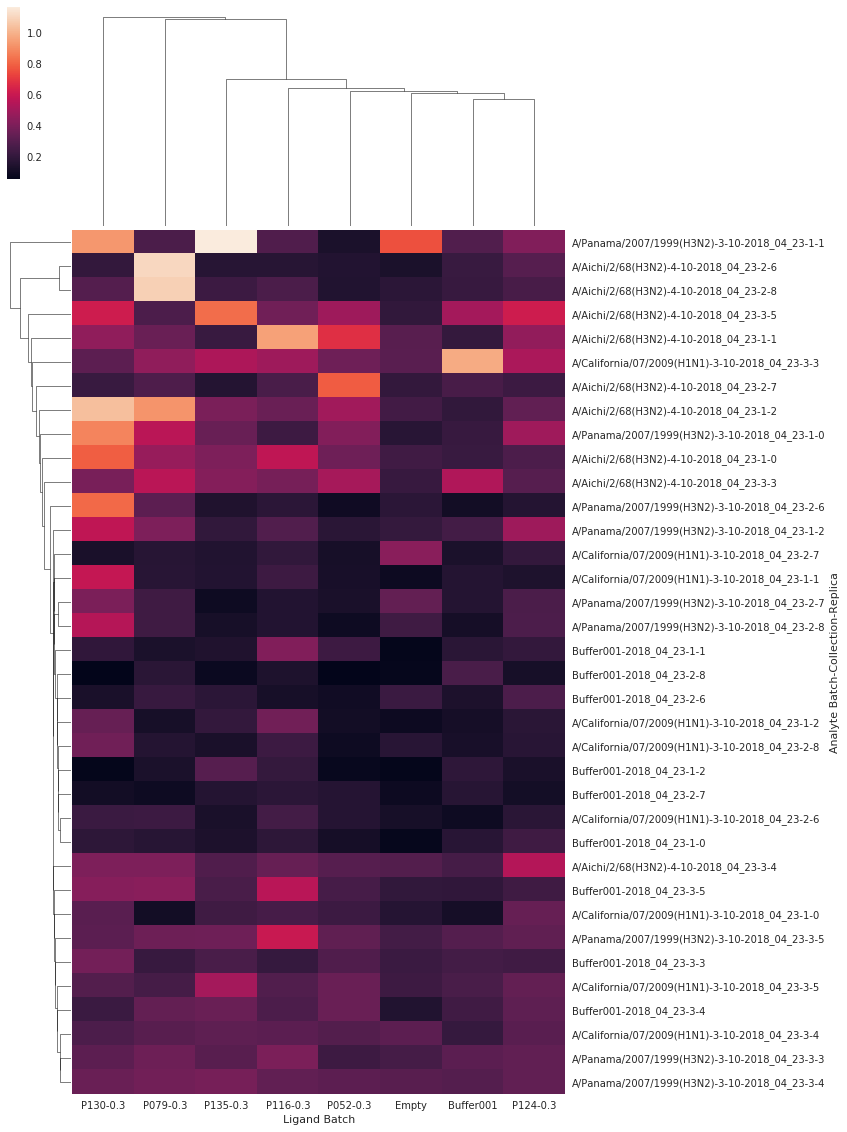

In [26]:
sns.clustermap(data_elisa.x,  method="single",figsize=(10,20))

## pca

In [27]:
model_pca = data_elisa.x_pca_fit()
elisa_pca = model_pca.transform(data_elisa.x)

In [28]:
#model_pca.scalings_

In [29]:
# creating colors for pca
le = preprocessing.LabelEncoder()
le.fit(data_elisa.y_names)
cs = le.transform(data_elisa.y_names)
colors =cs.astype(float) / cs.max()

In [30]:
trace1 = go.Scatter3d(
    x=elisa_pca[:,0],
    y=elisa_pca[:,1],
    z=elisa_pca[:,2],
    text = data_elisa.y_names+"<br>"+data_elisa.x.index.get_level_values("Collection"),
    mode='markers',
    hoverinfo='text',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        color=colors,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)

this = [trace1]
layout = go.Layout(
    #scene=dict(
    #    xaxis = dict(showspikes=False),
    #    yaxis = dict(showspikes=False),
    #    zaxis = dict(showspikes=False),

        

     #   )
    )
fig = go.Figure(data=this, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

In [31]:
complete = pd.DataFrame(columns=["Test", "Train"])
com = data_elisa.collections.unique().values

complete.at[0, "Test"] = com
complete.at[0, "Train"] = com

In [32]:
#no cross-validation on different microwells possible possible without 
ana = a2.Analysis(data_elisa, train_test=complete)
ana1 = a2.Analysis(data_elisa_norm1, train_test=complete)
ana2 = a2.Analysis(data_elisa_norm2, train_test=complete)
ana3 = a2.Analysis(data_elisa_norm3, train_test=complete)
ana4 = a2.Analysis(data_elisa_norm4, train_test=complete)

ana.calculate_all()
ana1.calculate_all()
ana2.calculate_all()
ana3.calculate_all()
ana4.calculate_all()

*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****


In [33]:
def split_result(frame):
    result_dict = {}
    len_frame = int(len(frame)/3)
    result_dict["frame_NN"] = frame[:len_frame]
    result_dict["frame_DT"] = frame[len_frame:2*len_frame]
    result_dict["frame_LR"] = frame[2*len_frame:3*len_frame]
    return result_dict

In [34]:
result = split_result(ana.complete_information())
result1 = split_result(ana1.complete_information())
result2 = split_result(ana2.complete_information())
result3 = split_result(ana3.complete_information())
result4 = split_result(ana4.complete_information())


In [35]:
def render_result(data,name,ax,show=False,xlabel="",ylabel=""):
    sns.pointplot(data=data,y="y",x="TrueFalse",ci=None, join=False,hue="y", markers="|",ax=ax)
    for c in ax.collections:
        for of in c.get_offsets():
            ax.annotate("{:.2f}".format(of[0]), of)
    sns.swarmplot(data=data.reset_index().sort_values(by=["level_1","level_2"]),y="y",x="TrueFalse",hue="level_1",ax=ax,palette=sns.color_palette("inferno",n_colors=4))#, jitter=0.5)#, aspect=0.8)
    if not show:
        ax.legend_.remove()
    ax.set_title(name)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    

## Classification Results

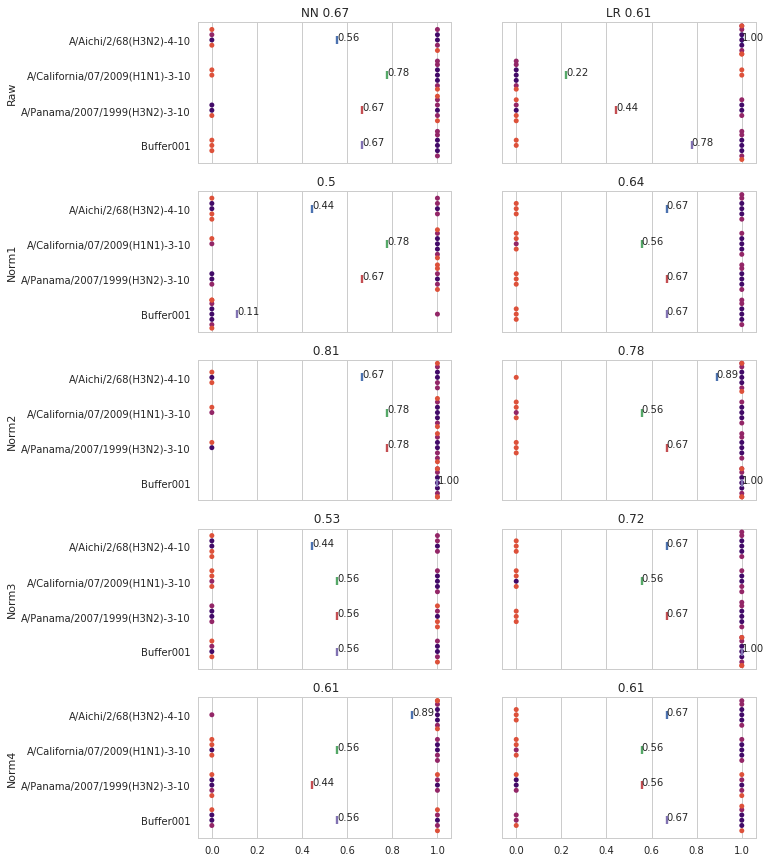

In [36]:
fig, ax = plt.subplots(ncols=2,nrows=5, figsize=(10,15),sharex=True, sharey=True)
#ax = sns.boxplot(data=frame_NN,y="y",x="TrueFalse",notch=True)

render_result(result["frame_NN"], "NN {:.02}".format(result["frame_NN"]["TrueFalse"].mean()), ax[0,0],ylabel="Raw")
#render_result(result["frame_DT"], "DT",ax[0,1])
render_result(result["frame_LR"], "LR {:.02}".format(result["frame_LR"]["TrueFalse"].mean()),ax[0,1])
render_result(result1["frame_NN"], " {:.02}".format(result1["frame_NN"]["TrueFalse"].mean()), ax[1,0],ylabel="Norm1")
#render_result(result1["frame_DT"], "",ax[1,1])
render_result(result1["frame_LR"], " {:.02}".format(result1["frame_LR"]["TrueFalse"].mean()),ax[1,1])
render_result(result2["frame_NN"], " {:.02}".format(result2["frame_NN"]["TrueFalse"].mean()), ax[2,0],ylabel="Norm2")
#render_result(result2["frame_DT"], "",ax[2,1])
render_result(result2["frame_LR"], " {:.02}".format(result2["frame_LR"]["TrueFalse"].mean()),ax[2,1])
render_result(result3["frame_NN"], " {:.02}".format(result3["frame_NN"]["TrueFalse"].mean()), ax[3,0],ylabel="Norm3")
#render_result(result3["frame_DT"], "",ax[3,1],show=True)
render_result(result3["frame_LR"], " {:.02}".format(result3["frame_LR"]["TrueFalse"].mean()),ax[3,1])
render_result(result4["frame_NN"], " {:.02}".format(result4["frame_NN"]["TrueFalse"].mean()), ax[4,0],ylabel="Norm4")
#render_result(result3["frame_DT"], "",ax[3,1],show=True)
render_result(result4["frame_LR"], " {:.02}".format(result4["frame_LR"]["TrueFalse"].mean()),ax[4,1])

SyntaxError: unexpected EOF while parsing (<ipython-input-37-558459330029>, line 1)

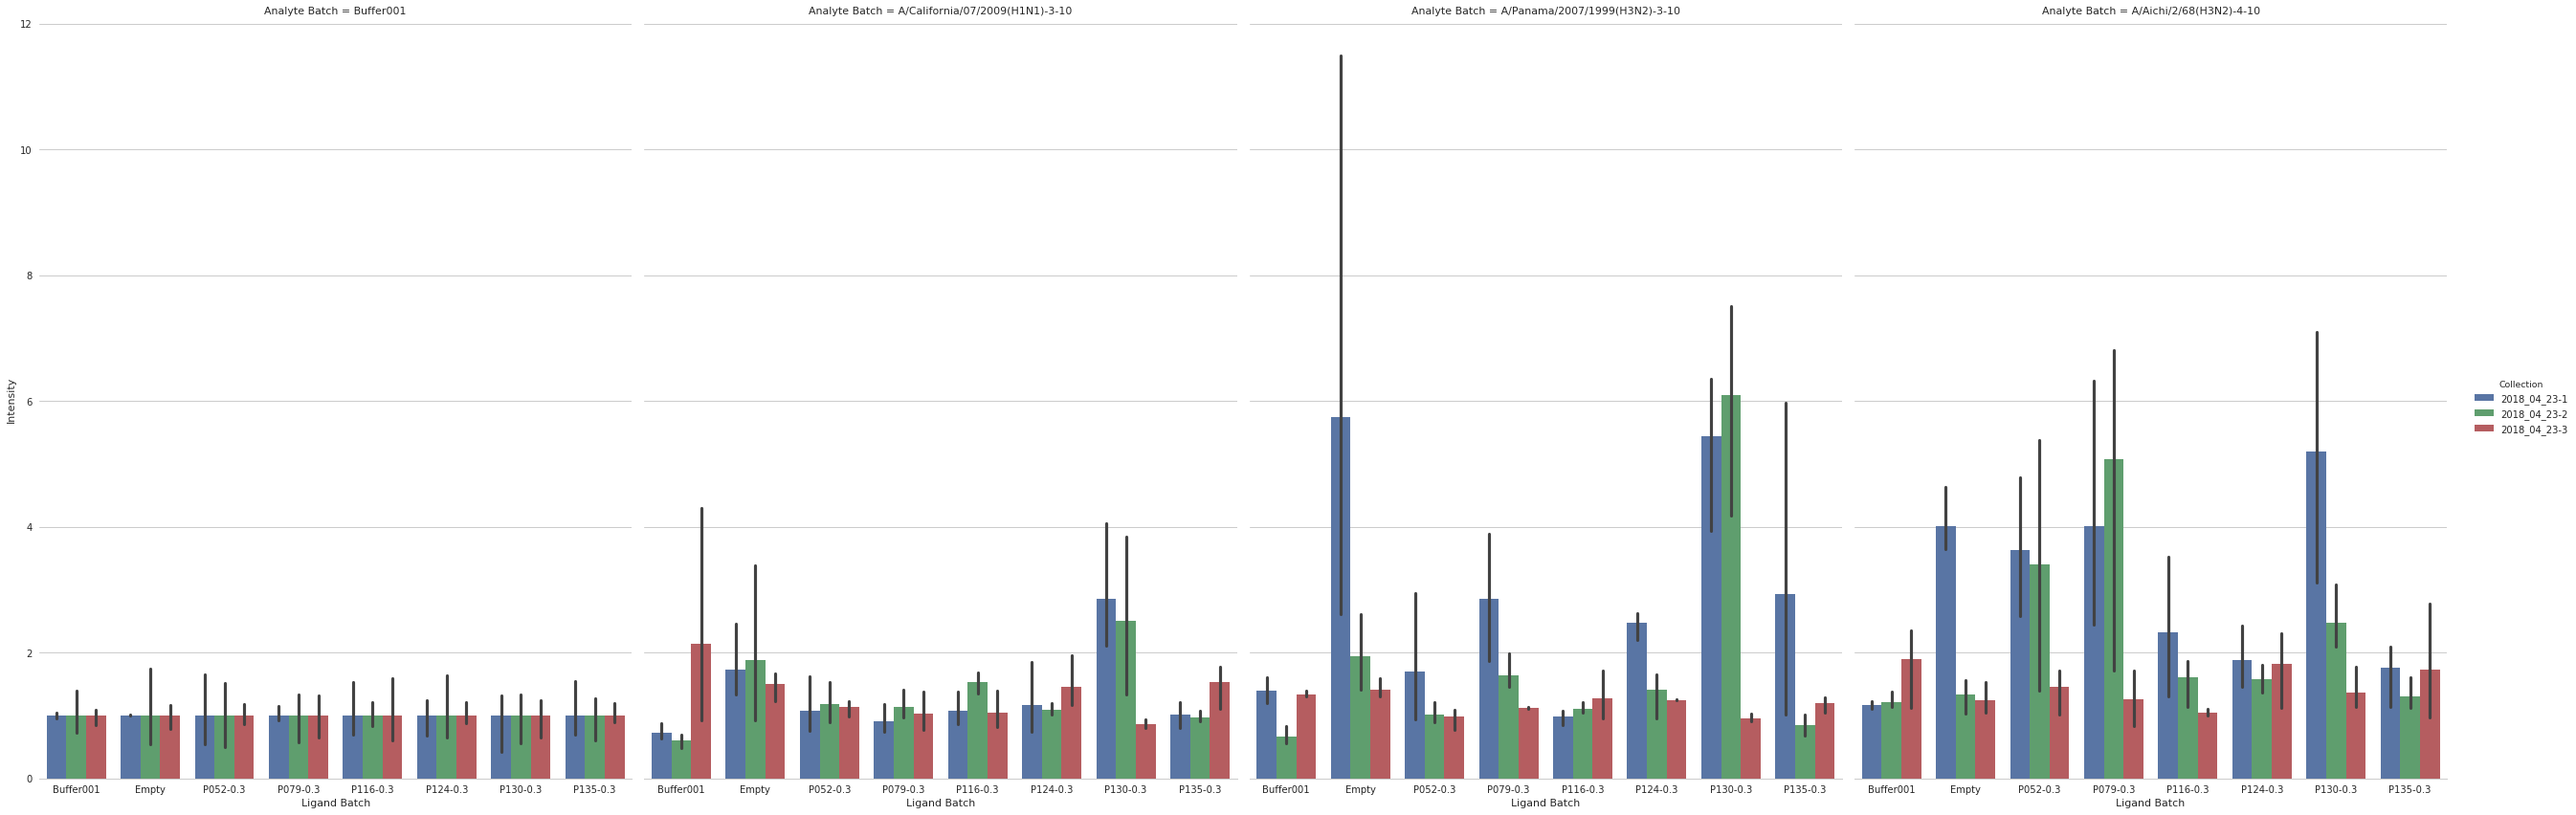

In [39]:
sns.set(style="whitegrid")
g = sns.factorplot(x="Ligand Batch", y="Intensity", col="Analyte Batch", hue="Collection",kind="bar", data=data_elisa_norm2.spots_pd, size=12, aspect=.75)#,capsize=.2)
g.despine(left=True)
plt.show()